In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# XGBoost Offset Model

## Model_1

In [ ]:
import pandas as pd 
import numpy as np 
import xgboost as xgb
from scipy.optimize import fmin_powell
from sklearn.metrics import cohen_kappa_score

def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y,weights='quadratic')
    
def get_params():
    
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 240
    params["subsample"] = 0.9
    params["colsample_bytree"] = 0.67
    params["silent"] = 1
    params["max_depth"] = 6
    plst = list(params.items())

    return plst
    
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

# global variables
#columns_to_drop = ['Id', 'Response', 'Medical_History_10','Medical_History_24']
columns_to_drop = ['Id', 'Response']
xgb_num_rounds = 800
num_classes = 8
eta_list = [0.05] * 200 
eta_list = eta_list + [0.02] * 500
eta_list = eta_list + [0.01] * 100

print("Load the data using pandas")
train = pd.read_csv('/content/drive/MyDrive/PrudentialData/train.csv')
test = pd.read_csv('/content/drive/MyDrive/PrudentialData/test.csv')


# combine train and test
all_data = train.append(test)

# Found at https://www.kaggle.com/marcellonegro/prudential-life-insurance-assessment/xgb-offset0501/run/137585/code
# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

# factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

print('Eliminate missing values')    
# Use -1 for any others
all_data.fillna(-1, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
test = all_data[all_data['Response']<1].copy()

# convert data to xgb data structure
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['Response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test['Response'].values)    

# get the parameters for xgboost
plst = get_params()
print(plst)      

# train model
model = xgb.train(plst, xgtrain, xgb_num_rounds, learning_rates=eta_list) 

# get preds
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train score is:', eval_wrapper(train_preds, train['Response'])) 
test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
train_preds = np.clip(train_preds, -0.99, 8.99)
test_preds = np.clip(test_preds, -0.99, 8.99)

# train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
data = np.vstack((train_preds, train_preds, train['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(data, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  

# apply offsets to test
data = np.vstack((test_preds, test_preds, test['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds = np.round(np.clip(data[1], 1, 8)).astype(int)

preds_out = pd.DataFrame({"Id": test['Id'].values, "Response": final_test_preds})
preds_out = preds_out.set_index('Id')
preds_out.to_csv('xgb_offset_submission_2.csv')

Load the data using pandas
Eliminate missing values
[('objective', 'reg:linear'), ('eta', 0.05), ('min_child_weight', 240), ('subsample', 0.9), ('colsample_bytree', 0.67), ('silent', 1), ('max_depth', 6)]
Train score is: 0.6383863471928359
Optimization terminated successfully.
         Current function value: -0.691444
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.691444
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.691444
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.691969
         Iterations: 2
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: -0.691969
         Iterations: 1
         Function evaluations: 32
Optimization terminated successfully.
         Current function value:

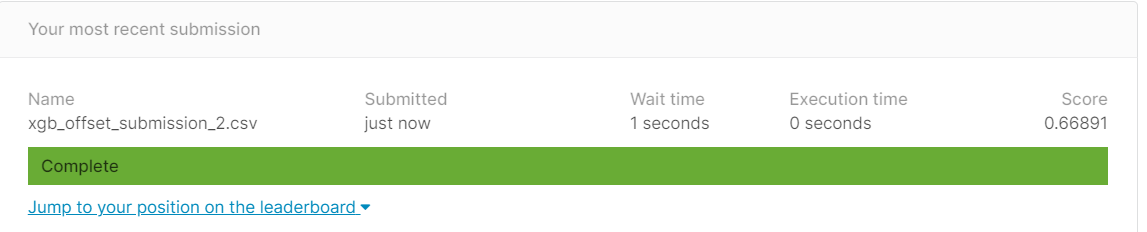

## Model_2

In [ ]:
import pandas as pd 
import numpy as np 
import xgboost as xgb
from scipy.optimize import fmin_powell
from sklearn.metrics import cohen_kappa_score

def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y,weights='quadratic')
    
def get_params():
    
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 60
    params["subsample"] = 0.9
    params["colsample_bytree"] = 0.67
    params["silent"] = 1
    params["max_depth"] = 6
    plst = list(params.items())

    return plst
    
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

# global variables
#columns_to_drop = ['Id', 'Response', 'Medical_History_10','Medical_History_24']
columns_to_drop = ['Id', 'Response']
xgb_num_rounds = 800
num_classes = 8
eta_list = [0.05] * 200 
eta_list = eta_list + [0.02] * 500
eta_list = eta_list + [0.01] * 100

print("Load the data using pandas")
train = pd.read_csv('/content/drive/MyDrive/PrudentialData/train.csv')
test = pd.read_csv('/content/drive/MyDrive/PrudentialData/test.csv')


# combine train and test
all_data = train.append(test)

# Found at https://www.kaggle.com/marcellonegro/prudential-life-insurance-assessment/xgb-offset0501/run/137585/code
# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

# factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

print('Eliminate missing values')    
# Use -1 for any others
all_data.fillna(-1, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
test = all_data[all_data['Response']<1].copy()

# convert data to xgb data structure
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['Response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test['Response'].values)    

# get the parameters for xgboost
plst = get_params()
print(plst)      

# train model
model = xgb.train(plst, xgtrain, xgb_num_rounds, learning_rates=eta_list) 

# get preds
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train score is:', eval_wrapper(train_preds, train['Response'])) 
test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
train_preds = np.clip(train_preds, -0.99, 8.99)
test_preds = np.clip(test_preds, -0.99, 8.99)

# train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
data = np.vstack((train_preds, train_preds, train['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(data, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  

# apply offsets to test
data = np.vstack((test_preds, test_preds, test['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds = np.round(np.clip(data[1], 1, 8)).astype(int)

preds_out = pd.DataFrame({"Id": test['Id'].values, "Response": final_test_preds})
preds_out = preds_out.set_index('Id')
preds_out.to_csv('xgb_offset_submission_3.csv')

Load the data using pandas
Eliminate missing values
[('objective', 'reg:linear'), ('eta', 0.05), ('min_child_weight', 60), ('subsample', 0.9), ('colsample_bytree', 0.67), ('silent', 1), ('max_depth', 6)]
Train score is: 0.6618241595919974
Optimization terminated successfully.
         Current function value: -0.715727
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.715727
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.715727
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.716021
         Iterations: 2
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -0.716074
         Iterations: 1
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 

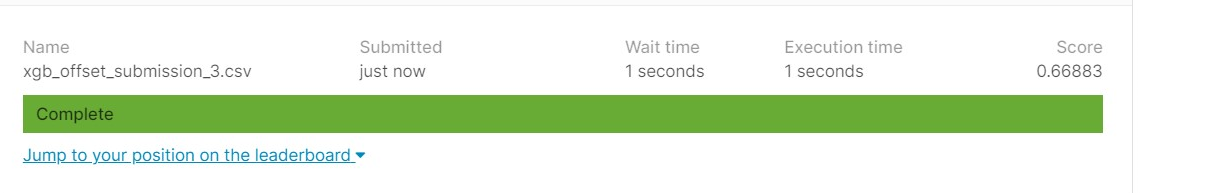

## Model_3

In [6]:
import pandas as pd 
import numpy as np 
import xgboost as xgb
from scipy.optimize import fmin_powell
from sklearn.metrics import cohen_kappa_score

def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y,weights='quadratic')
    
def get_params():
    
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 60
    params["subsample"] = 0.9
    params["colsample_bytree"] = 0.60
    params["silent"] = 1
    params["max_depth"] = 8
    plst = list(params.items())

    return plst
    
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

# global variables
#columns_to_drop = ['Id', 'Response', 'Medical_History_10','Medical_History_24']
columns_to_drop = ['Id', 'Response']
xgb_num_rounds = 800
num_classes = 8
eta_list = [0.05] * 200 
eta_list = eta_list + [0.02] * 500
eta_list = eta_list + [0.01] * 100

print("Load the data using pandas")
train = pd.read_csv('/content/drive/MyDrive/PrudentialData/train.csv')
test = pd.read_csv('/content/drive/MyDrive/PrudentialData/test.csv')


# combine train and test
all_data = train.append(test)

# Found at https://www.kaggle.com/marcellonegro/prudential-life-insurance-assessment/xgb-offset0501/run/137585/code
# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

# factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

print('Eliminate missing values')    
# Use -1 for any others
all_data.fillna(-1, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
test = all_data[all_data['Response']<1].copy()

# convert data to xgb data structure
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['Response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test['Response'].values)    

# get the parameters for xgboost
plst = get_params()
print(plst)      

# train model
model = xgb.train(plst, xgtrain, xgb_num_rounds, learning_rates=eta_list) 

# get preds
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train score is:', eval_wrapper(train_preds, train['Response'])) 
test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
train_preds = np.clip(train_preds, -0.99, 8.99)
test_preds = np.clip(test_preds, -0.99, 8.99)

# train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
data = np.vstack((train_preds, train_preds, train['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(data, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  

# apply offsets to test
data = np.vstack((test_preds, test_preds, test['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds = np.round(np.clip(data[1], 1, 8)).astype(int)

preds_out = pd.DataFrame({"Id": test['Id'].values, "Response": final_test_preds})
preds_out = preds_out.set_index('Id')
# preds_out.to_csv('xgb_offset_submission_4.csv')

Load the data using pandas
Eliminate missing values
[('objective', 'reg:linear'), ('eta', 0.05), ('min_child_weight', 60), ('subsample', 0.9), ('colsample_bytree', 0.6), ('silent', 1), ('max_depth', 8)]
Train score is: 0.7029430751160213
Optimization terminated successfully.
         Current function value: -0.754532
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.754532
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.754532
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.755011
         Iterations: 3
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -0.755022
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: -

In [7]:
model.save_model("/content/drive/MyDrive/PrudentialData/BestXGBOffsetModel.h5")

In [14]:
import pickle
# filepath = open("/content/drive/MyDrive/PrudentialData/BestXGBOffsetModel.h5",'wb')
# model1 = pickle.dump(model, filepath)
filepath = open("/content/drive/MyDrive/PrudentialData/BestXGBOffsetModel.h5",'rb')
model1 = pickle.load(filepath)

[04:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


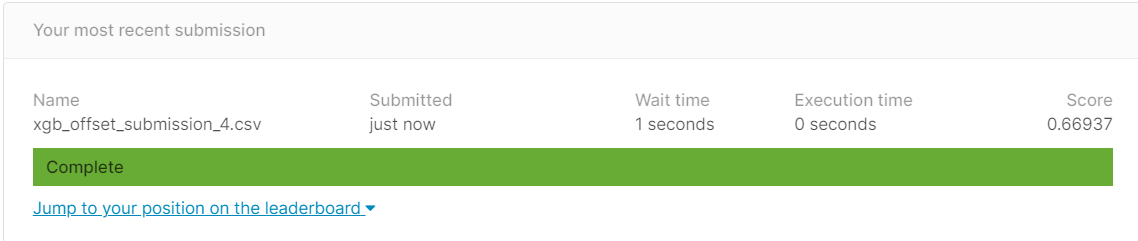

In [4]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model Name", "Parameters", "CV Score", "Test Score"]

table.add_row(["XGBoost", '{objective: "reg:linear", eta: 0.05, min_child_weight: 240, subsample: 0.9, \n colsample_bytree: 0.67, silent: 1, max_depth: 6, num_rounds: 800}','0.6384','0.6689'])
table.add_row(["XGBoost", '{objective: "reg:linear", eta: 0.05, min_child_weight: 60, subsample: 0.9, \n colsample_bytree: 0.67, silent: 1, max_depth: 6, num_rounds: 800}','0.6618','0.6688'])
table.add_row(["XGBoost", '{objective: "reg:linear", eta: 0.05, min_child_weight: 60, subsample: 0.9, \n colsample_bytree: 0.6, silent: 1, max_depth: 8, num_rounds: 800}','0.7029','0.6694'])
print (table)


+------------+------------------------------------------------------------------------------+----------+------------+
| Model Name |                                  Parameters                                  | CV Score | Test Score |
+------------+------------------------------------------------------------------------------+----------+------------+
|  XGBoost   | {objective: "reg:linear", eta: 0.05, min_child_weight: 240, subsample: 0.9,  |  0.6384  |   0.6689   |
|            |       colsample_bytree: 0.67, silent: 1, max_depth: 6, num_rounds: 800}      |          |            |
|  XGBoost   | {objective: "reg:linear", eta: 0.05, min_child_weight: 60, subsample: 0.9,   |  0.6618  |   0.6688   |
|            |       colsample_bytree: 0.67, silent: 1, max_depth: 6, num_rounds: 800}      |          |            |
|  XGBoost   | {objective: "reg:linear", eta: 0.05, min_child_weight: 60, subsample: 0.9,   |  0.7029  |   0.6694   |
|            |       colsample_bytree: 0.6, silent: 1, m

In [53]:
##SMOTE with some feature engineering on Raw Data
import pandas as pd 
import numpy as np 
import xgboost as xgb
from scipy.optimize import fmin_powell
from sklearn.metrics import cohen_kappa_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y,weights='quadratic')
    
def get_params():
    
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 60
    params["subsample"] = 0.9
    params["colsample_bytree"] = 0.60
    params["silent"] = 1
    params["max_depth"] = 8
    plst = list(params.items())

    return plst
    
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

# global variables
#columns_to_drop = ['Id', 'Response', 'Medical_History_10','Medical_History_24']
columns_to_drop = ['Id', 'Response']
xgb_num_rounds = 800
num_classes = 8
eta_list = [0.05] * 200 
eta_list = eta_list + [0.02] * 500
eta_list = eta_list + [0.01] * 100

print("Load the data using pandas")
train = pd.read_csv('/content/drive/MyDrive/PrudentialData/train.csv')
test = pd.read_csv('/content/drive/MyDrive/PrudentialData/test.csv')



# combine train and test
all_data = train.append(test)

# Found at https://www.kaggle.com/marcellonegro/prudential-life-insurance-assessment/xgb-offset0501/run/137585/code
# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

# factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

print('Eliminate missing values')    
# Use -1 for any others
all_data.fillna(-1, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
test = all_data[all_data['Response']<1].copy()

#oversampling
oversample = SMOTE()
train_xi, train_yi =  oversample.fit_resample(train.drop('Response',axis=1), train['Response'])
train = pd.DataFrame(np.concatenate((train_xi,train_yi.reshape(-1,1)),axis=1),columns=list(train.columns.drop('Response')) + ['Response'])
train.head()


# convert data to xgb data structure
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['Response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test['Response'].values)    

# get the parameters for xgboost
plst = get_params()
print(plst)      

# train model
model = xgb.train(plst, xgtrain, xgb_num_rounds, learning_rates=eta_list) 

# get preds
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train score is:', eval_wrapper(train_preds, train['Response'])) 
test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
train_preds = np.clip(train_preds, -0.99, 8.99)
test_preds = np.clip(test_preds, -0.99, 8.99)

# train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
data = np.vstack((train_preds, train_preds, train['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(data, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  

# apply offsets to test
data = np.vstack((test_preds, test_preds, test['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds = np.round(np.clip(data[1], 1, 8)).astype(int)

preds_out = pd.DataFrame({"Id": test['Id'].values, "Response": final_test_preds})
preds_out = preds_out.set_index('Id')
# preds_out.to_csv('xgb_offset_submission_4.csv')

Load the data using pandas
Eliminate missing values
[('objective', 'reg:linear'), ('eta', 0.05), ('min_child_weight', 60), ('subsample', 0.9), ('colsample_bytree', 0.6), ('silent', 1), ('max_depth', 8)]
Train score is: 0.7461971600323687
Optimization terminated successfully.
         Current function value: -0.767979
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.767979
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.772010
         Iterations: 2
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: -0.774501
         Iterations: 2
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: -0.785902
         Iterations: 2
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -

In [55]:
# preds_out.to_csv('SMOTExgb_offset_submission_4.csv')
filepath = "/content/drive/MyDrive/PrudentialData/SMOTEBestXgboostOffsetModel.h5"
model.save_model(filepath)

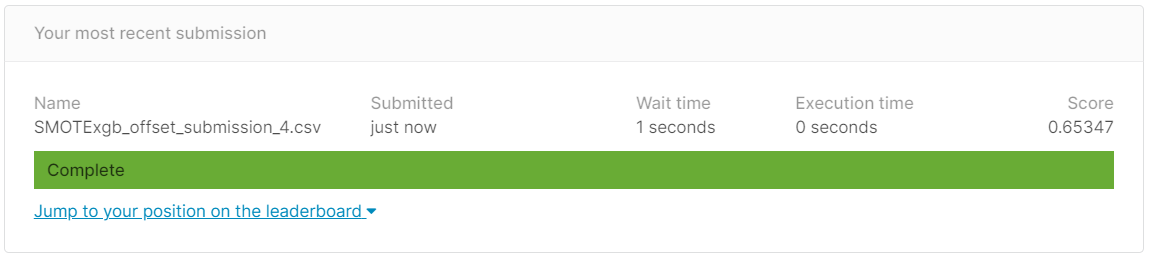

In [66]:
### Checking the features scores from the above trained model
scores = dict(sorted(model.get_score().items(), key = lambda x:x[1], reverse= True))

#keeping only features with scores >100
imp_features = []
for i, j in scores.items():
  if j>100:
    imp_features.append(i)

print(f"{len(imp_features)} Features have scores greater than 100 out of {len(model.feature_names)}.")


105 Features have scores greater than 100 out of 130.


In [110]:
import pandas as pd 
import numpy as np 
import xgboost as xgb
from scipy.optimize import fmin_powell
from sklearn.metrics import cohen_kappa_score
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')


def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y,weights='quadratic')

def get_params():
    
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 60
    params["subsample"] = 0.9
    params["colsample_bytree"] = 0.60
    params["silent"] = 1
    params["max_depth"] = 8
    plst = list(params.items())

    return plst
    
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

# global variables
#columns_to_drop = ['Id', 'Response', 'Medical_History_10','Medical_History_24']
# columns_to_drop = ['Id', 'Response']
xgb_num_rounds = 800
num_classes = 8
eta_list = [0.05] * 200 
eta_list = eta_list + [0.02] * 500
eta_list = eta_list + [0.01] * 100

print("Load the data using pandas")
RawDataFE = open("/content/drive/MyDrive/PrudentialData/RawDataFE", 'rb')
train, cv, test = pickle.load(RawDataFE)
test_xi = np.array(test)

#oversampling
oversample = SMOTE()
train_xi, train_yi =  oversample.fit_resample(train.drop('Response',axis=1), train['Response'])
cv_xi, cv_yi =  oversample.fit_resample(cv.drop('Response',axis=1), cv['Response'])
# test_xi, test_yi =  oversample.fit_resample(test.drop('Response',axis=1), test['Response'])
print("Shapes after Oversampling : ", train_xi.shape, cv_xi.shape)

print("Features we are modelling: " ,train.columns)
# convert data to xgb data structure
xgtrain = xgb.DMatrix(train_xi, train_yi)
xgcv = xgb.DMatrix(cv_xi, cv_yi)
xgtest = xgb.DMatrix(test_xi,label=None)    

# get the parameters for xgboost
plst = get_params()
print(plst)      

# # train model
model_all = xgb.train(plst, xgtrain, xgb_num_rounds, learning_rates=eta_list) 

# # get preds
train_preds = model_all.predict(xgtrain, ntree_limit=model_all.best_iteration)
print('Train score is:', eval_wrapper(train_preds, train_yi))

cv_preds = model_all.predict(xgcv, ntree_limit=model_all.best_iteration)
print('CV score is:', eval_wrapper(cv_preds, cv_yi))

test_preds = model_all.predict(xgtest, ntree_limit=model_all.best_iteration)
train_preds = np.clip(train_preds, -0.99, 8.99)
test_preds = np.clip(test_preds, -0.99, 8.99)

# train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
data = np.vstack((train_preds, train_preds, train_yi))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(data, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  

# apply offsets to test
data = np.vstack((test_preds, test_preds, np.zeros((test_xi.shape[0],))))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds_all = np.round(np.clip(data[1], 1, 8)).astype(int)

preds_out_all = pd.DataFrame({"Id": test['Id'].values, "Response": final_test_preds_all})
preds_out_all = preds_out_all.set_index('Id')
# preds_out.to_csv('xgb_offset_submission_4.csv')

Train score is: 0.7580031842082544
CV score is: 0.6454828966431746
Optimization terminated successfully.
         Current function value: -0.779620
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.779620
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.783154
         Iterations: 2
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -0.785184
         Iterations: 2
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -0.799156
         Iterations: 2
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -0.803144
         Iterations: 2
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: -0.803162
         Iterations: 1
 

In [117]:
# preds_out_all.to_csv("SMOTE_RawDataFEXGBOOST_offset.csv")
filepath = open("/content/drive/MyDrive/PrudentialData/SMOTE_RAWDATA_FE_BestXgboostOffsetModel.h5", 'wb')
pickle.dump(model_all, filepath)

In [118]:
### Checking the features scores from the above trained model
scores = dict(sorted(model.get_score().items(), key = lambda x:x[1], reverse= True))
scores
# #keeping only features with scores >100
# imp_features = []
# for i, j in scores.items():
#   if j>100:
#     imp_features.append(i)

# print(f"{len(imp_features)} Features have scores greater than 100 out of {len(model.feature_names)}.")


{'BMI': 2982,
 'BMI_Age': 1894,
 'Employment_Info_1': 1929,
 'Employment_Info_2': 1147,
 'Employment_Info_3': 454,
 'Employment_Info_4': 994,
 'Employment_Info_5': 249,
 'Employment_Info_6': 1926,
 'Family_Hist_1': 850,
 'Family_Hist_2': 1168,
 'Family_Hist_3': 1483,
 'Family_Hist_4': 1413,
 'Family_Hist_5': 1172,
 'Ht': 1605,
 'Ins_Age': 2057,
 'Insurance_History_1': 524,
 'Insurance_History_2': 248,
 'Insurance_History_3': 405,
 'Insurance_History_4': 627,
 'Insurance_History_5': 1211,
 'Insurance_History_7': 446,
 'Insurance_History_8': 703,
 'Insurance_History_9': 260,
 'InsuredInfo_1': 482,
 'InsuredInfo_2': 117,
 'InsuredInfo_3': 1445,
 'InsuredInfo_4': 254,
 'InsuredInfo_5': 216,
 'InsuredInfo_6': 828,
 'InsuredInfo_7': 180,
 'Med_Keywords_Count': 1690,
 'Medical_History_1': 1864,
 'Medical_History_10': 118,
 'Medical_History_11': 172,
 'Medical_History_12': 305,
 'Medical_History_13': 651,
 'Medical_History_14': 112,
 'Medical_History_15': 1930,
 'Medical_History_16': 490,
 'Me

In [135]:
#less number of baselearners

import pandas as pd 
import numpy as np 
import xgboost as xgb
from scipy.optimize import fmin_powell
from sklearn.metrics import cohen_kappa_score
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')


def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y,weights='quadratic')

def get_params():
    
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.3
    params["max_depth"] = 5
    plst = list(params.items())

    return plst

# params["min_child_weight"] = 30 #used to contrl overfitting
# params["subsample"] = 0.9
# params["colsample_bytree"] = 0.60
# params["silent"] = 1
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

# global variables
#columns_to_drop = ['Id', 'Response', 'Medical_History_10','Medical_History_24']
# columns_to_drop = ['Id', 'Response']
xgb_num_rounds = 500
num_classes = 8
eta_list = [0.1] * 200 
eta_list = eta_list + [0.3] * 300
# eta_list = eta_list + [0.01] * 100

print("Load the data using pandas")
RawDataFE = open("/content/drive/MyDrive/PrudentialData/RawDataFE", 'rb')
train, cv, test = pickle.load(RawDataFE)
test_xi = np.array(test)

#oversampling
oversample = SMOTE()
train_xi, train_yi =  oversample.fit_resample(train.drop('Response',axis=1), train['Response'])
cv_xi, cv_yi =  oversample.fit_resample(cv.drop('Response',axis=1), cv['Response'])
# test_xi, test_yi =  oversample.fit_resample(test.drop('Response',axis=1), test['Response'])
print("Shapes after Oversampling : ", train_xi.shape, cv_xi.shape)

print("Features we are modelling: " ,train.columns)
# convert data to xgb data structure
xgtrain = xgb.DMatrix(train_xi, train_yi)
xgcv = xgb.DMatrix(cv_xi, cv_yi)
xgtest = xgb.DMatrix(test_xi,label=None)    

# get the parameters for xgboost
plst = get_params()
print(plst)      

# # train model
model_100BL = xgb.train(plst, xgtrain, xgb_num_rounds, learning_rates= eta_list) 

# # get preds
train_preds = model_100BL.predict(xgtrain, ntree_limit=model_100BL.best_iteration)
print('Train score is:', eval_wrapper(train_preds, train_yi))

cv_preds = model_100BL.predict(xgcv, ntree_limit=model_100BL.best_iteration)
print('CV score is:', eval_wrapper(cv_preds, cv_yi))

test_preds = model_100BL.predict(xgtest, ntree_limit=model_100BL.best_iteration)
train_preds = np.clip(train_preds, -0.99, 8.99)
test_preds = np.clip(test_preds, -0.99, 8.99)

# train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
data = np.vstack((train_preds, train_preds, train_yi))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(data, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  

# apply offsets to test
data = np.vstack((test_preds, test_preds, np.zeros((test_xi.shape[0],))))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds_100BL = np.round(np.clip(data[1], 1, 8)).astype(int)

preds_out_100BL = pd.DataFrame({"Id": test['Id'].values, "Response": final_test_preds_100BL})
preds_out_100BL = preds_out_100BL.set_index('Id')
# preds_out.to_csv('xgb_offset_submission_4.csv')

Load the data using pandas
Shapes after Oversampling :  (124728, 86) (31184, 86)
Features we are modelling:  Index(['Id', 'Product_Info_1', 'Product_Info_2', 'Product_Info_4',
       'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Wt',
       'BMI', 'Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6',
       'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4',
       'InsuredInfo_5', 'InsuredInfo_7', 'Insurance_History_1',
       'Insurance_History_2', 'Insurance_History_4', 'Insurance_History_5',
       'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9',
       'Family_Hist_1', 'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4',
       'Family_Hist_5', 'Medical_History_1', 'Medical_History_2',
       'Medical_History_3', 'Medical_History_4', 'Medical_History_5',
       'Medical_History_6', 'Medical_History_7', 'Medical_History_8',
       'Medical_History_9', 'Medical_History_10', 'Medical_History_11',
       'Medical_History_1

In [137]:
# filepath = open("/content/drive/MyDrive/PrudentialData/model_100BL_BestXgboostOffsetModel.h5", 'wb')
# pickle.dump(model_100BL, filepath)
preds_out_100BL.to_csv('preds_out_100BLxgb_offset_submission_4.csv')